# Non Homogeneous Hidden Markov Model

## Library Loading and Configuration

In [71]:
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.5.0"  # Change this path according to your R installation.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import IntVector

# Enable conversion between pandas and R
pandas2ri.activate()

# Load the R base package
base = importr('base')
# Load the package depmixS4
depmixS4 = importr("depmixS4")
# Set the seed in R for reproducibility
r('set.seed(2030)')
# Set seed in Python for reproducibility
np.random.seed(2030)

## Data loading and preparation:

In [72]:
covid_data = pd.read_excel('../data/covid_data.xlsx')

In [73]:
covid_data.columns

Index(['IM_interno', 'IM_externo', 'inc_pc_comuna', 'TasaCasosAcumulados',
       'Personas_hogar_promedio', 'inmigrantes', 'total_hog_hacinados',
       'indic_precariedad_vivienda', 'Comuna', 'fecha', 'dias', 'por_educ_sup',
       'porc_postgrado', 'IPS_2020', 'Prioridad_2020', 'CODIGO', 'year',
       'month', 'paso', 'paso_etiqueta', 'Fecha inicio cuarentena',
       'Fecha término cuarentena', 'Casos_Diarios_Brutos',
       'Casos_Diarios_Brutos_MM7'],
      dtype='object')

In [74]:
covid_data.rename(columns={'IM_interno': 'Internal_Mobility_Index',
                           'IM_externo': 'External_Mobility_Index',
                           'inc_pc_comuna': 'Per_Capita_Income',
                           'TasaCasosAcumulados': 'Cumulative_Cases_Rate',
                           'Personas_hogar_promedio': 'Average_Household_Persons',
                           'inmigrantes': 'Inmigrants',
                           'total_hog_hacinados': 'Total_Households_Housed',
                           'indic_precariedad_vivienda': 'Housing_Precariousness_Index',
                           'Comuna': 'Commune',
                           'fecha': 'Date',
                           'dias': 'Days',
                           'por_educ_sup': 'Higher_Education_Percentage',
                           'porc_postgrado': 'Postgraduade_Percentage',
                           'IPS_2020': 'Social_Priority_Index_2020',
                           'Prioridad_2020': 'Priority_2020',
                           'CODIGO':'Code',
                           'year': 'Year',
                           'month': 'Month',
                           'paso': 'Step',
                           'paso_etiqueta': 'Step_Label',
                           'Fecha inicio cuarentena': 'Quarantine_Start_Date',
                           'Fecha término cuarentena': 'Quarantine_End_Date',
                           'Casos_Diarios_Brutos': 'Gross_Daily_Cases',
                           'Casos_Diarios_Brutos_MM7': 'Gross_Daily_Cases_Mobile_Average_7_Days'}, inplace=True)

In [75]:
covid_data.columns

Index(['Internal_Mobility_Index', 'External_Mobility_Index',
       'Per_Capita_Income', 'Cumulative_Cases_Rate',
       'Average_Household_Persons', 'Inmigrants', 'Total_Households_Housed',
       'Housing_Precariousness_Index', 'Commune', 'Date', 'Days',
       'Higher_Education_Percentage', 'Postgraduade_Percentage',
       'Social_Priority_Index_2020', 'Priority_2020', 'Code', 'Year', 'Month',
       'Step', 'Step_Label', 'Quarantine_Start_Date', 'Quarantine_End_Date',
       'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days'],
      dtype='object')

### Dictionary of variables:
- **'Internal_Mobility_Index'**: Index of internal mobility of the communes.
- **'External_Mobility_Index'**: Index of external mobility of the communes.
- **'Per_Capita_Income'**: Per capita income of the communes.
- **'Cumulative_Cases_Rate'**: Cumulative case rate per 100,000 population.
- **'Average_Household_Persons'**: Average number of persons per household in the communes.
- **'Inmigrants'**: Percentage of immigrants in the communes.
- **'Total_Households_Housed'**: Percentage of overcrowded households in the communes.
- **'Housing_Precariousness_Index'**: Indicator of housing precariousness in the municipalities.
- **'Commune'**: Name of the commune.
- **'Date'**: Date of observation.
- **'Days'**: Number of days since the beginning of the records.
- **'Higher_Education_Percentage'**: Percentage of people with higher education in the communes.
- **'Postgraduade_Percentage'**: Percentage of people with a postgraduate degree in the communes.
- **'Social_Priority_Index_2020'**: Social Priority Index 2020 of the communes.
- **'Priority_2020'**: 2020 Social Priority of the communes.
- **'Code'**: Code of the commune.
- **'Year'**: Year of observation.
- **'Month'**: Month of observation.
- **'Step'**: Commune Step by Step Plan.
- **'Step_Label'**: Label of the commune's passage in the Step by Step Plan.
- **'Quarantine_Start_Date'**: Quarantine start date.
- **'Quarantine_End_Date'**: Date of end of quarantine.
- **'Gross_Daily_Cases'**: Number of gross daily cases.
- **'Gross_Daily_Cases_Mobile_Average_7_Days'**: Number of gross daily cases with 7-day moving average.

In [76]:
# Remove rows with null values in the relevant columns:
covid_data = covid_data.dropna(subset=['Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 'Date'])
# Reset index and add row_id for merge:
covid_data = covid_data.reset_index(drop=True)
covid_data['row_id'] = covid_data.index  # for subsequent merge

## Exploratory Data Analysis (EDA):

### Gross Daily Cases with 7-day moving average:

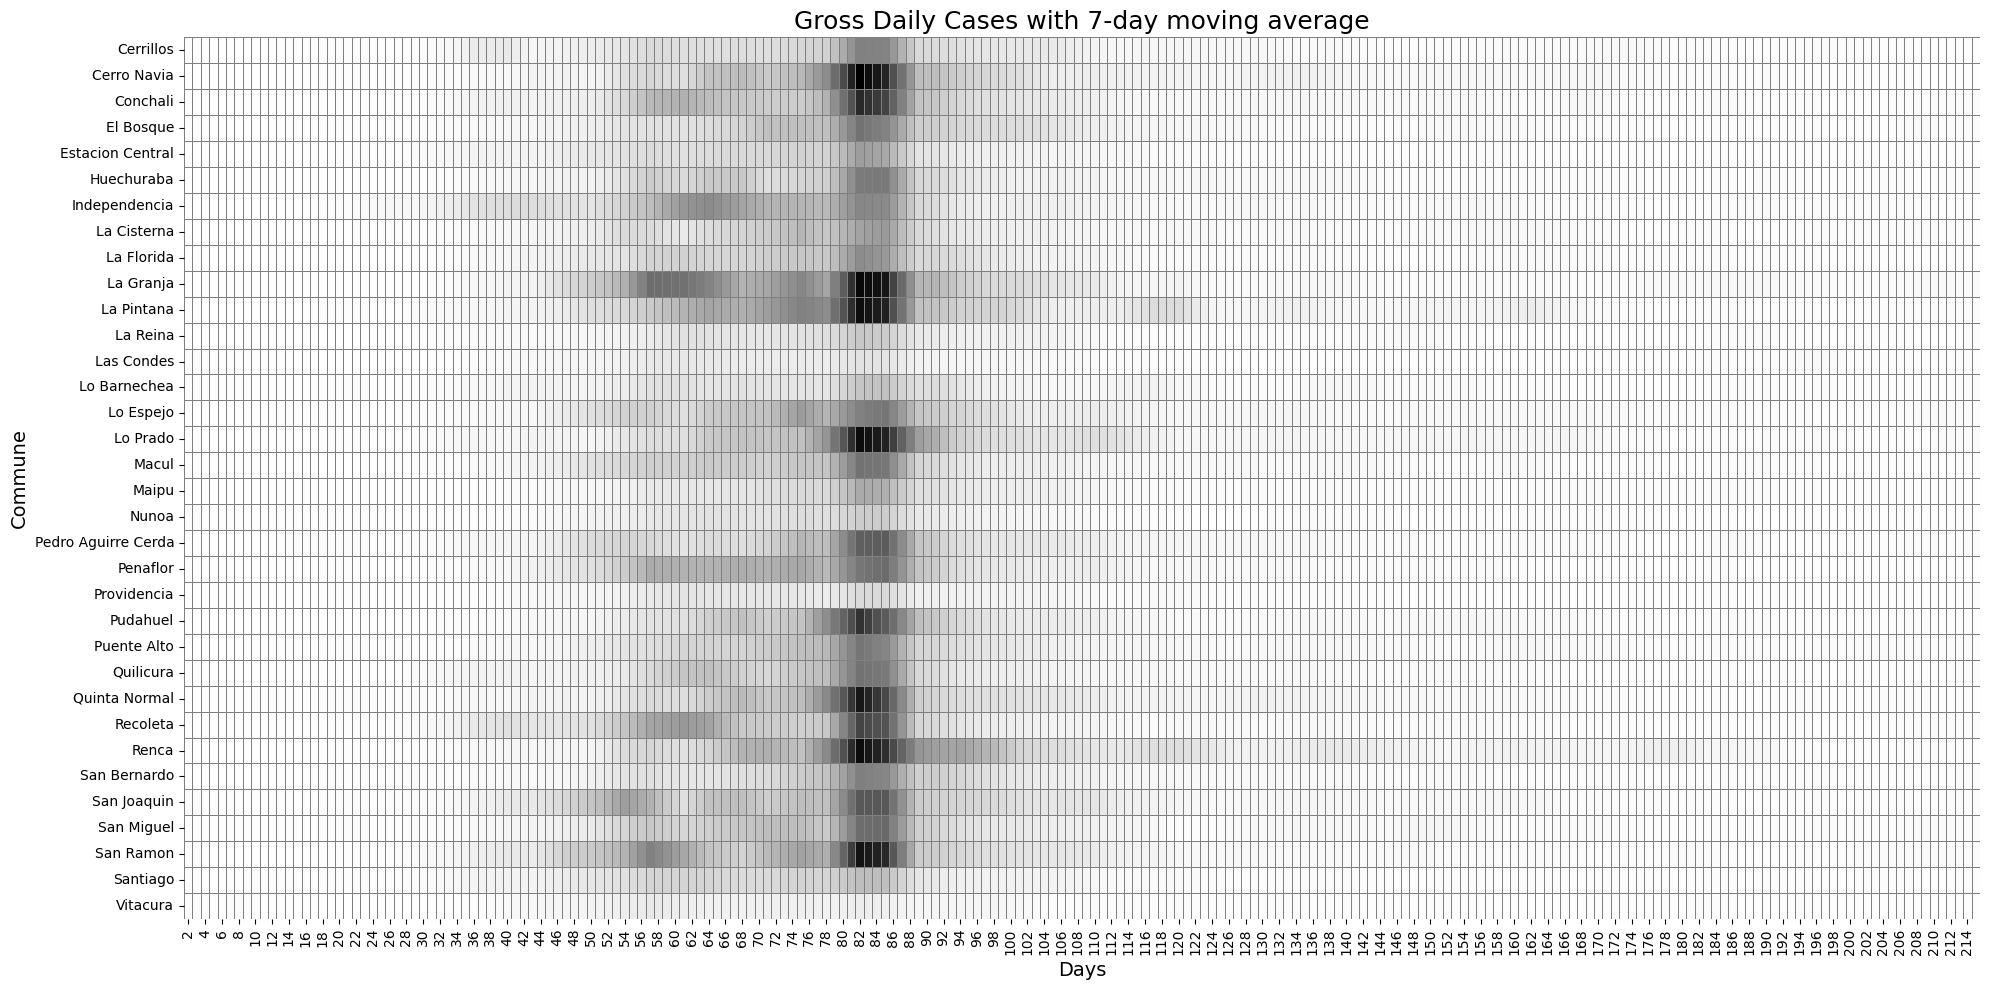

In [79]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Gross_Daily_Cases_Mobile_Average_7_Days')

plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys', 
    linewidths=0.5,
    linecolor='gray',
    cbar=False  
)

plt.title('Gross Daily Cases with 7-day moving average', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

plt.tight_layout()

plt.show()

### Internal Mobility Index of each commune over time:

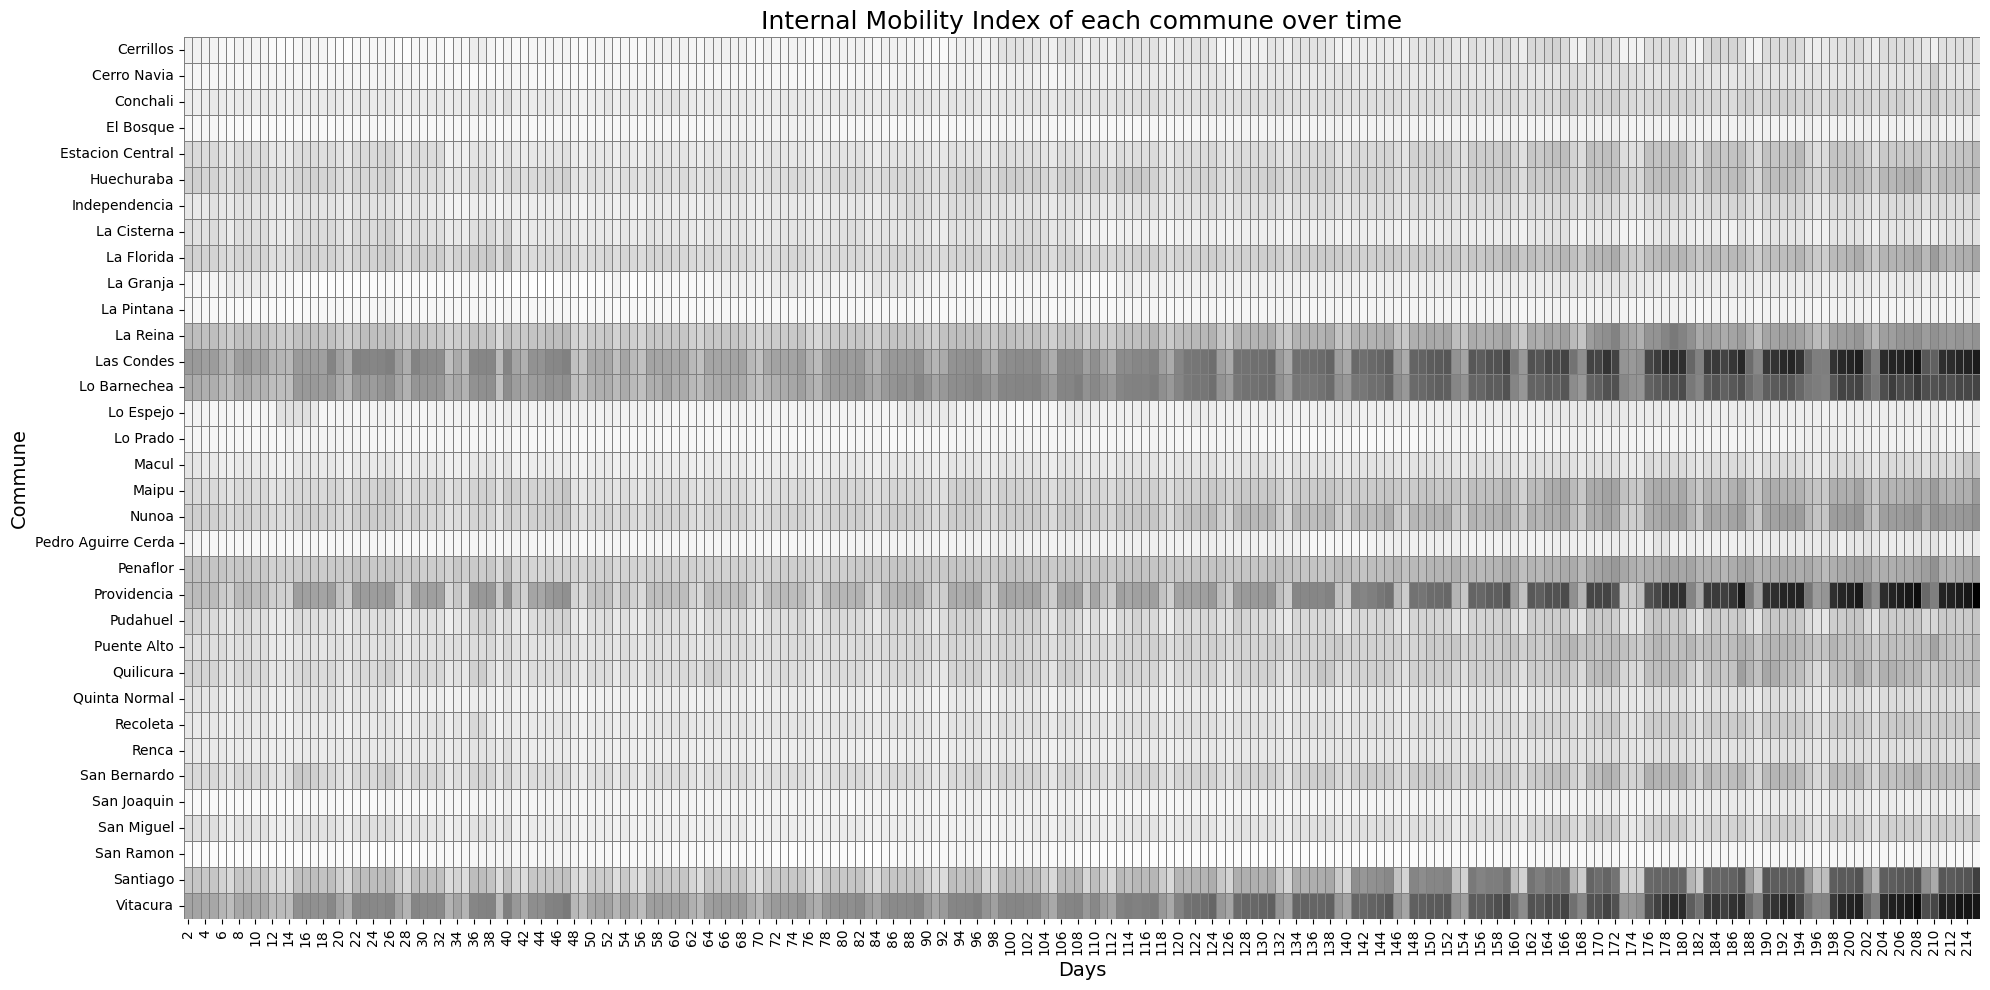

In [83]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='Internal_Mobility_Index')

# Crear el heatmap sin la barra de color (cbar=False)
plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys',  # Usar los colores personalizados
    linewidths=0.5,
    linecolor='gray',
    cbar=False  # Desactivar la barra de color
)

# Títulos y etiquetas
plt.title('Internal Mobility Index of each commune over time', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

# Ajustar el espaciado para evitar bordes innecesarios
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### External Mobility Index of each commune over time:

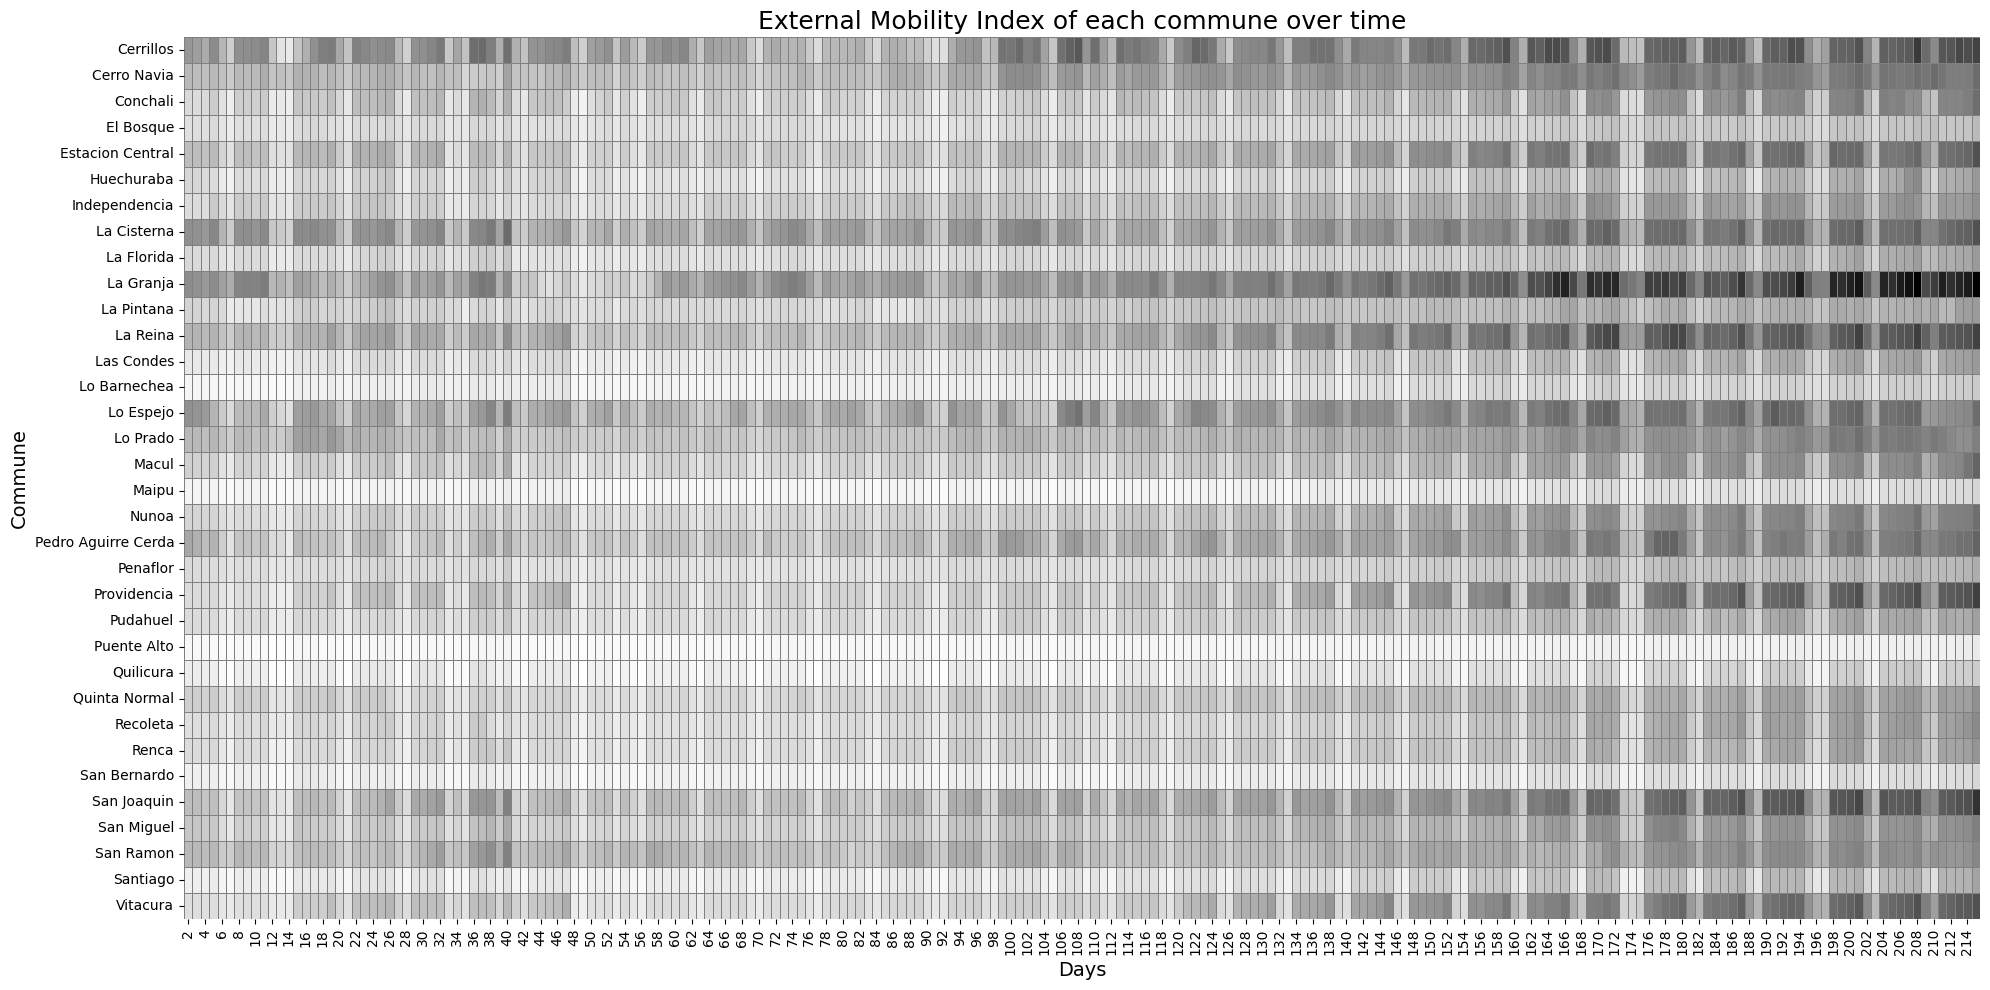

In [84]:
covid_pivot = covid_data.pivot(index='Commune', columns='Days', values='External_Mobility_Index')


plt.figure(figsize=(20, 10))
sns.heatmap(
    covid_pivot,
    cmap='Greys', 
    linewidths=0.5,
    linecolor='gray',
    cbar=False  
)

plt.title('External Mobility Index of each commune over time', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)

plt.tight_layout()

plt.show()

## Definition of HMM model formulas:

Create `ntimes` from clean data

In [85]:
# Create `ntimes` from clean data
ntimes = IntVector(covid_data.groupby("Commune")["Days"].count().tolist())

# Validate consistency:
print(sum(ntimes))        # Total observations (must match len(covid_data))
print(len(covid_data))    # To check alignment

7276
7276


### Convert to R format:

In [86]:
pandas2ri.activate()
covid_data_r = pandas2ri.py2rpy(covid_data)

The transition probabilities between states depend on the covariates ‘IM_internal’, ‘IM_external’ and the commune

In [87]:
# Main observation:
hmm_formula = r("as.formula")("Gross_Daily_Cases_Mobile_Average_7_Days ~ 1")

# Transition covariates:
trans_formula = r("as.formula")("~ Internal_Mobility_Index + External_Mobility_Index + Commune")

# Distribution of observation:
gaussian_family = r['gaussian']()

### Creation of the HMM model:

In [88]:
hmm_model = depmixS4.depmix( 
    response=hmm_formula, # Main observation
    nstates=3,  # Number of hidden states
    family=gaussian_family,  # Distribution of observation
    data=covid_data_r, # Data
    transition=trans_formula, # Transition covariates
    ntimes=ntimes # Number of observations per group
)

print("HMM model configured:")
print(hmm_model)

HMM model configured:
Initial state probabilities model 
  pr1   pr2   pr3 
0.333 0.333 0.333 

Transition model for state (component) 1 
Model of type multinomial (mlogit), formula: ~Internal_Mobility_Index + External_Mobility_Index + Commune
Coefficients: 
                           St1 St2 St3
(Intercept)                  0   0   0
Internal_Mobility_Index      0   0   0
External_Mobility_Index      0   0   0
CommuneCerro Navia           0   0   0
CommuneConchali              0   0   0
CommuneEl Bosque             0   0   0
CommuneEstacion Central      0   0   0
CommuneHuechuraba            0   0   0
CommuneIndependencia         0   0   0
CommuneLa Cisterna           0   0   0
CommuneLa Florida            0   0   0
CommuneLa Granja             0   0   0
CommuneLa Pintana            0   0   0
CommuneLa Reina              0   0   0
CommuneLas Condes            0   0   0
CommuneLo Barnechea          0   0   0
CommuneLo Espejo             0   0   0
CommuneLo Prado              0   0   0


## Model adjustment:

In [89]:
# Adjust the HMM model
hmm_fitted = depmixS4.fit(hmm_model)

# Verify adjusted model information
print("\nAdjusted HMM model:")
print(hmm_fitted)


converged at iteration 39 with logLik: -22164.39 

Adjusted HMM model:
Convergence info: Log likelihood converged to within tol. (relative change) 
'log Lik.' -22164.39 (df=224)
AIC:  44776.78 
BIC:  46320.67 



## Extract sequence of states (Viterbi) and join with data:

In [90]:
# Extract the most probable sequence of states (Viterbi path and probabilities)
posterior_probs = r['slot'](hmm_fitted, "posterior")

# Convert posterior_probs to pandas DataFrame
viterbi_df = pandas2ri.rpy2py(posterior_probs).reset_index(drop=True)
viterbi_df['row_id'] = viterbi_df.index

### Merged with the original data:

In [91]:
viterbi_merged = pd.merge(viterbi_df, covid_data, on='row_id', how='inner')
print(viterbi_merged.head())

   state        S1            S2        S3  row_id  Internal_Mobility_Index  \
0    3.0  0.000000  0.000000e+00  1.000000       0                 1.970381   
1    3.0  0.000275  8.638053e-11  0.999725       1                 1.845790   
2    3.0  0.000348  6.453303e-07  0.999652       2                 1.678598   
3    3.0  0.000581  3.874640e-07  0.999418       3                 1.736766   
4    3.0  0.000707  6.989014e-06  0.999286       4                 1.331296   

   External_Mobility_Index  Per_Capita_Income  Cumulative_Cases_Rate  \
0                 7.804008          267197.56               2.248303   
1                 7.471452          267197.56               4.496605   
2                 6.891732          267197.56               4.496605   
3                 8.317872          267197.56               4.496605   
4                 6.378498          267197.56               4.496605   

   Average_Household_Persons  ...                Priority_2020   Code  Year  \
0            

In [97]:
# Rearrange the states to match the desired interpretation:
remap_estado = {1: 2, 2: 3, 3: 1}
viterbi_merged['Reordened_state'] = viterbi_merged['state'].map(remap_estado)


## Visualizations:

### Viterbi Sequence:

In [98]:
viterbi_merged.head()

,state,S1,S2,S3,row_id,Internal_Mobility_Index,External_Mobility_Index,Per_Capita_Income,Cumulative_Cases_Rate,Average_Household_Persons,...,Year,Month,Step,Step_Label,Quarantine_Start_Date,Quarantine_End_Date,Gross_Daily_Cases,Gross_Daily_Cases_Mobile_Average_7_Days,reordened_state,Reordened_state
0,3.0,0.000000,0.000000e+00,1.000000,0,1.970381,7.804008,267197.56,2.248303,3.145581,...,2020,3,0,Sin Medida,2020-05-05,2020-08-31,2.248303,2.248303,1,1
1,3.0,0.000275,8.638053e-11,0.999725,1,1.845790,7.471452,267197.56,4.496605,3.145581,...,2020,4,0,Sin Medida,2020-05-05,2020-08-31,2.248303,2.248303,1,1
2,3.0,0.000348,6.453303e-07,0.999652,2,1.678598,6.891732,267197.56,4.496605,3.145581,...,2020,4,0,Sin Medida,2020-05-05,2020-08-31,0.000000,1.498868,1,1
3,3.0,0.000581,3.874640e-07,0.999418,3,1.736766,8.317872,267197.56,4.496605,3.145581,...,2020,4,0,Sin Medida,2020-05-05,2020-08-31,0.000000,1.124151,1,1
4,3.0,0.000707,6.989014e-06,0.999286,4,1.331296,6.378498,267197.56,4.496605,3.145581,...,2020,4,0,Sin Medida,2020-05-05,2020-08-31,0.000000,0.899321,1,1


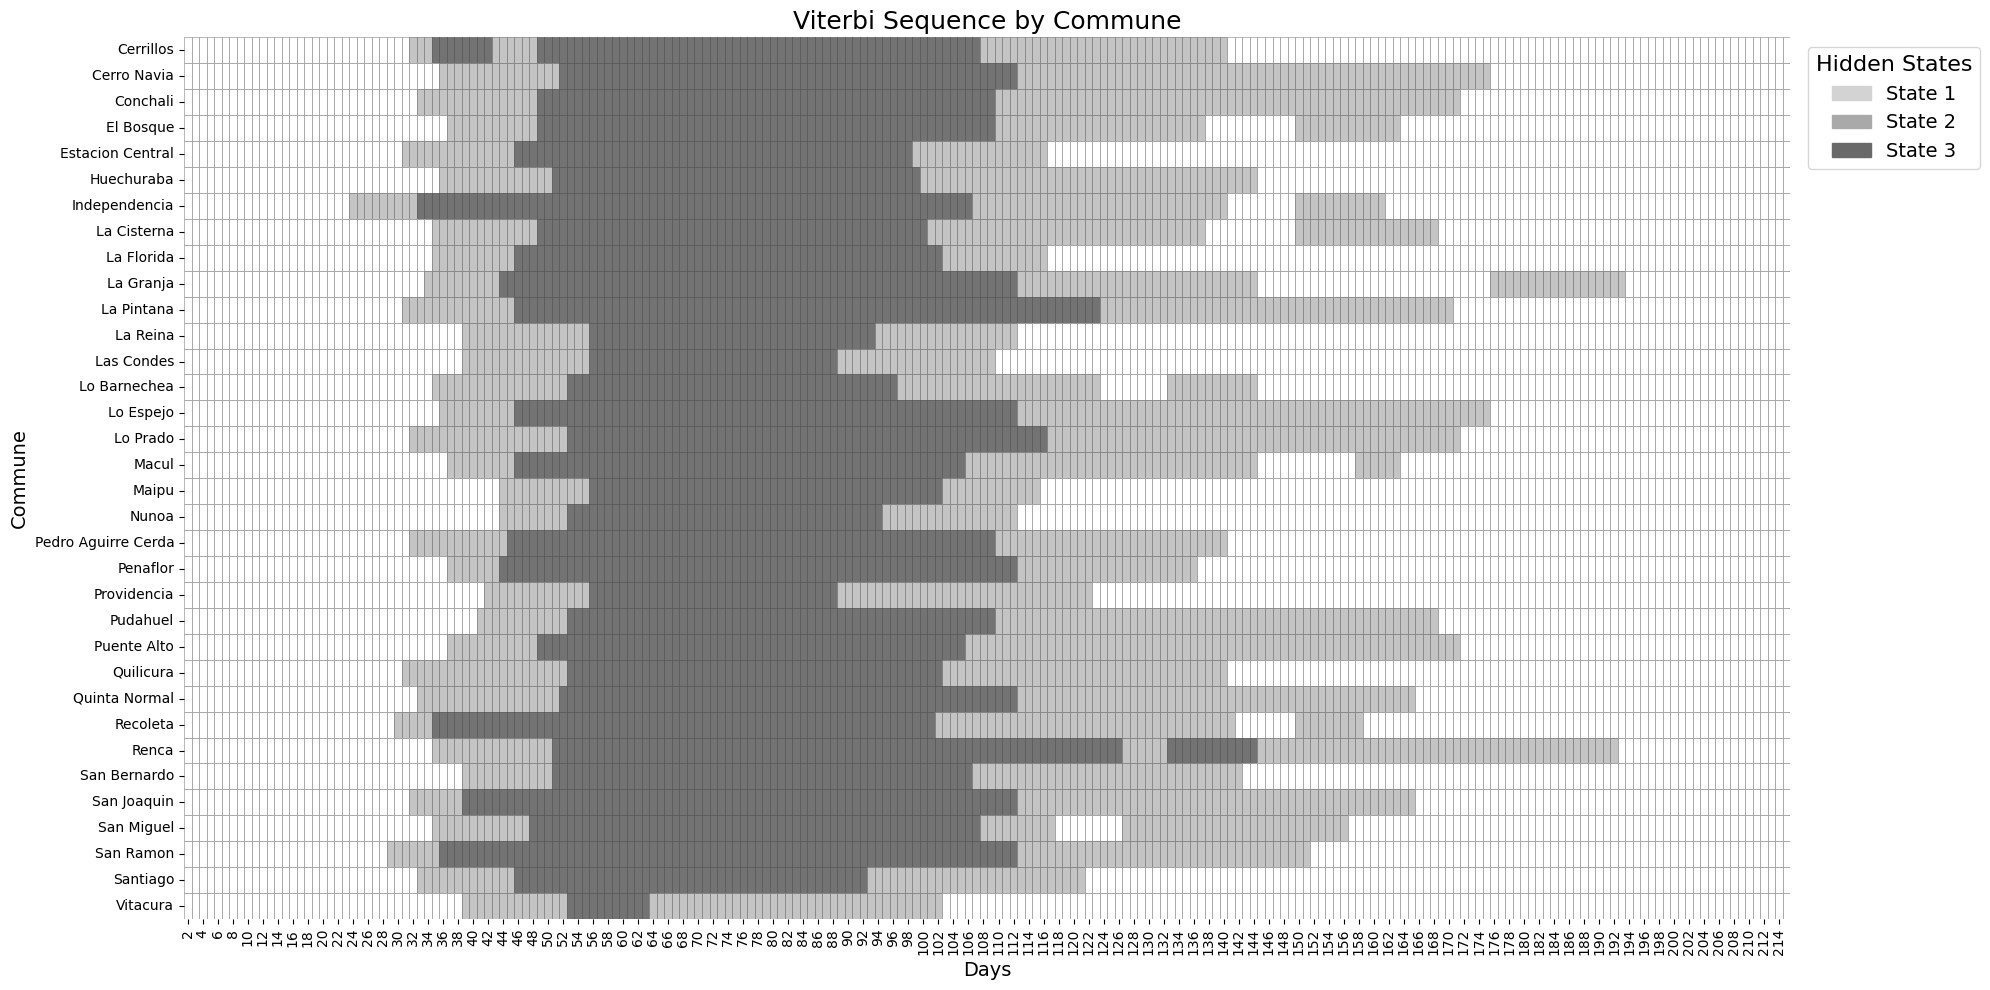

In [99]:
# Create the heatmap by pivoting the data
viterbi_pivot = viterbi_merged.pivot(index='Commune', columns='Days', values='Reordened_state')

# Define custom colors for each state
# Use custom colors for the states
#custom_colors = ['PeachPuff','LightSalmon', 'Tomato']  # Tomato (Severo)
# custom_colors grays
custom_colors= ['#D3D3D3', '#A9A9A9', '#696969']  # Light gray, medium gray and dark gray
# Create the mapping for the states
custom_palette = dict(zip([1, 2, 3], custom_colors))

plt.figure(figsize=(20, 10))
sns.heatmap(
    viterbi_pivot,
    #cmap=custom_colors,  # Use custom colors
    cmap='Greys',
    linewidths=0.5,
    linecolor='gray',
    alpha=0.55,  # Adjusting transparency
    cbar=False  # Deactivate the color bar
)

# Create a custom caption
legend_labels = ['State 1', 'State 2','State 3']  # State labels
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(custom_colors, legend_labels)]

# Add the legend closer
plt.legend(
    handles=legend_handles, 
    title="Hidden States", 
    bbox_to_anchor=(1.005, 1), 
    loc='upper left',          
    fontsize=14,               
    title_fontsize=16,        
)

# Titles and labels
plt.title('Viterbi Sequence by Commune', fontsize=18)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Commune', fontsize=14)


plt.tight_layout()

plt.show()

In [100]:
print(viterbi_merged[viterbi_merged['Commune']=='Vitacura']['Date'].min())
print(viterbi_merged[viterbi_merged['Commune']=='Vitacura']['Date'].max())

2020-03-31 00:00:00
2020-10-30 00:00:00


In [101]:
len(viterbi_merged[viterbi_merged['Commune']=='Vitacura'])

214

# Characterization of Hidden States:

In [102]:
eda_data = viterbi_merged[['Reordened_state', 'Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'Per_Capita_Income', 'Average_Household_Persons', 
                             'Inmigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']]


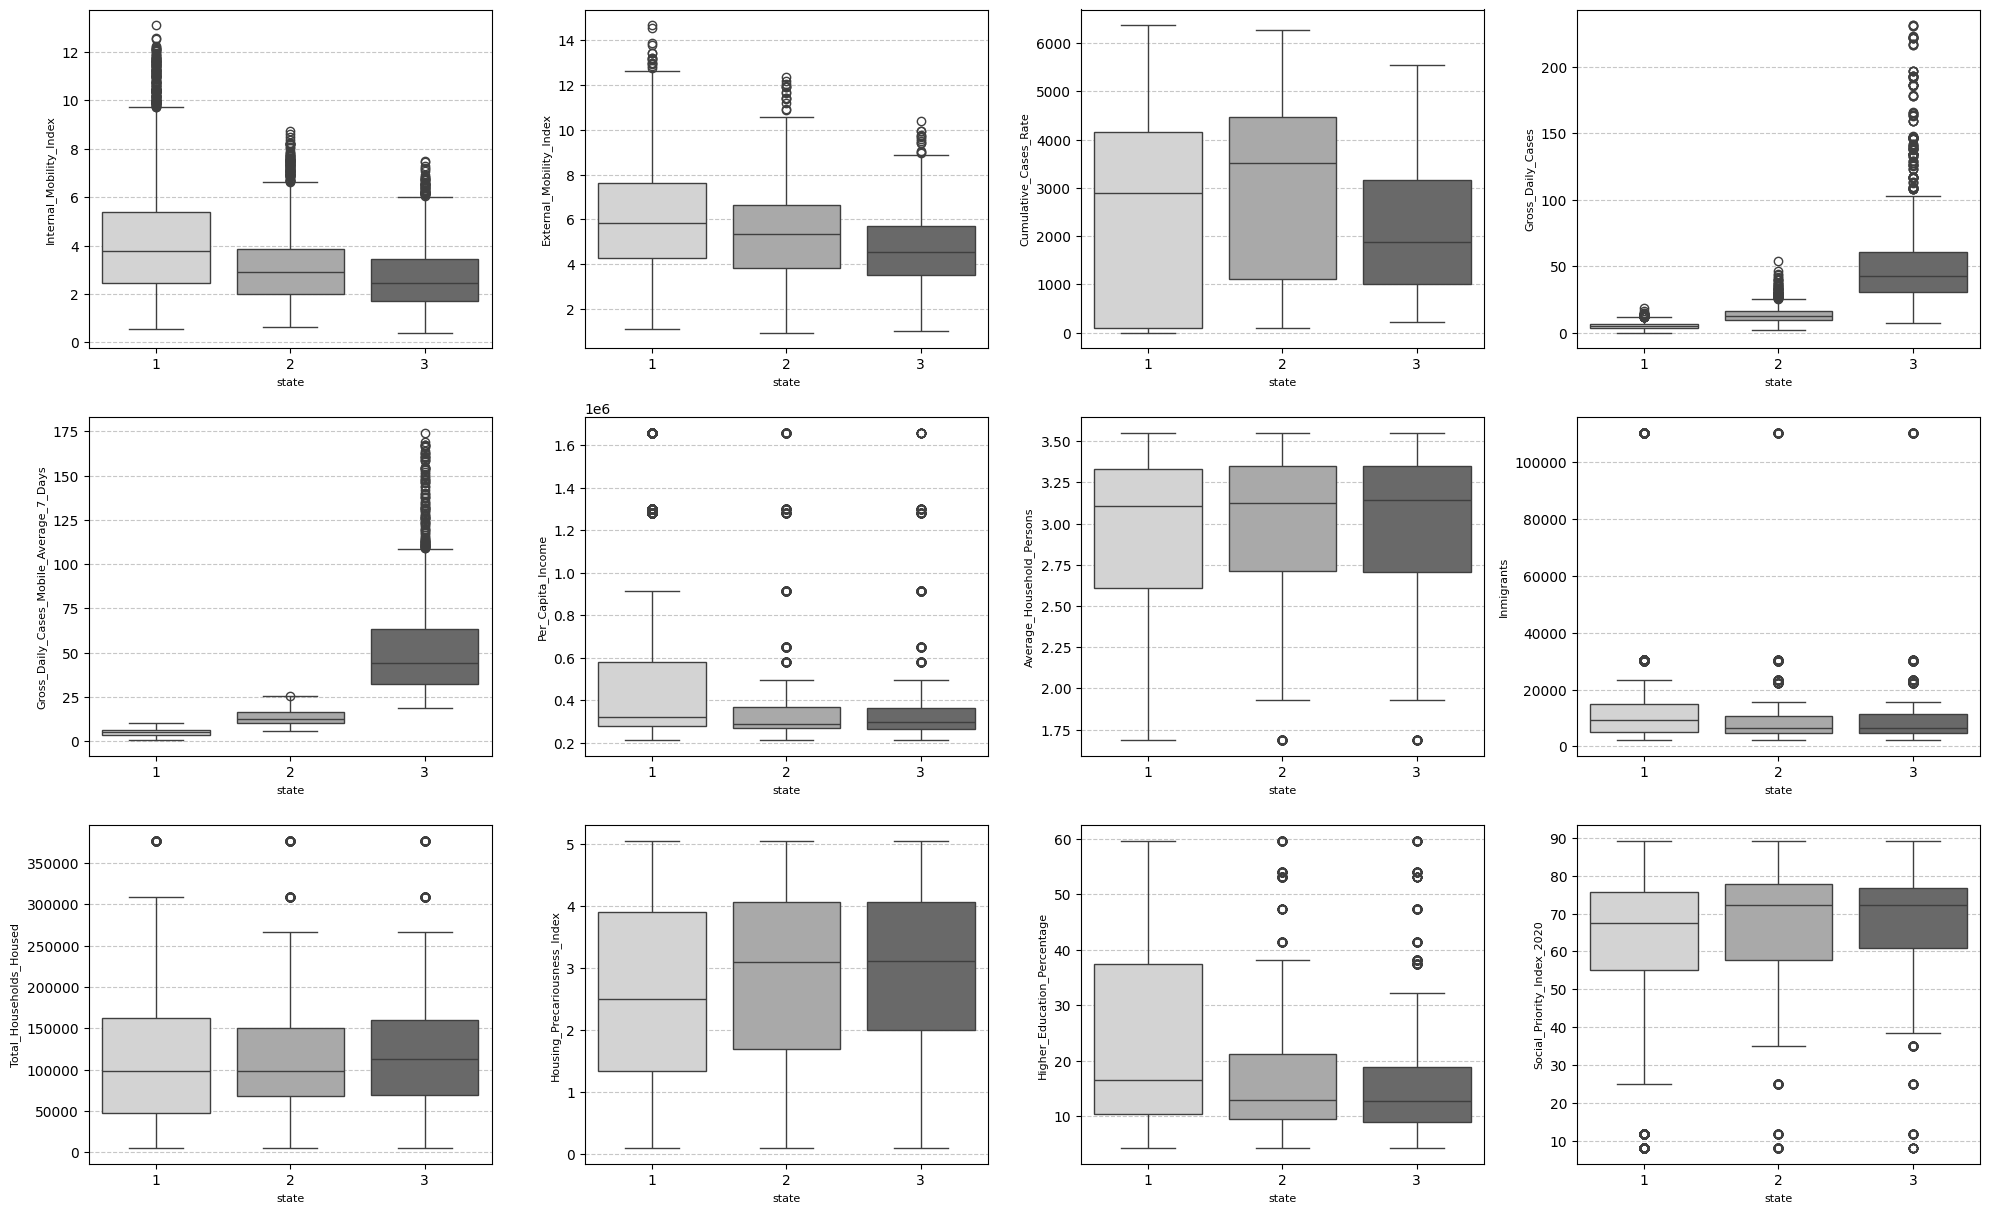

In [107]:
# Convertir la columna 'state' a cadenas con formato flotante
eda_data.loc[:, 'Reordened_state'] = eda_data['Reordened_state'].astype(str)

# Definir la paleta de colores basada en severidad
custom_palette = {
    '1': '#D3D3D3',  # Leve
    '2': '#A9A9A9',  # Moderado
    '3': '#696969'   # Severo
}

# Variables que queremos graficar
variables = ['Internal_Mobility_Index', 'External_Mobility_Index', 'Cumulative_Cases_Rate', 
                             'Gross_Daily_Cases', 'Gross_Daily_Cases_Mobile_Average_7_Days', 
                             'Per_Capita_Income', 'Average_Household_Persons', 
                             'Inmigrants', 'Total_Households_Housed',
                              'Housing_Precariousness_Index', 'Higher_Education_Percentage', 'Social_Priority_Index_2020']

# Configuración de la figura
n_rows = 5  # Número de filas
n_cols = 4  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Ajusta el tamaño total

# Aplanar los ejes para iterar más fácilmente
axes = axes.ravel()

# Crear los boxplots para cada variable sin leyendas individuales
for i, var in enumerate(variables):
    sns.boxplot(data=eda_data, x='Reordened_state', y=var, hue='Reordened_state', palette=custom_palette, ax=axes[i], dodge=False)
    #axes[i].legend_.remove()  # Eliminar leyenda individual
    #axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar cualquier subplot sobrante si hay más ejes que gráficos
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

_______________

In [52]:
# Crear una tabla con los días que cada comuna estuvo en cada estado
conteo_estados = viterbi_merged.groupby(['Comuna', 'state']).size().reset_index(name='Días_en_estado')

# Mostrar el resultado
print("Conteo de días en cada estado por comuna:")
print(conteo_estados)

Conteo de días en cada estado por comuna:
          Comuna  state  Días_en_estado
0      Cerrillos    1.0              67
1      Cerrillos    2.0              42
2      Cerrillos    3.0             105
3    Cerro Navia    1.0              61
4    Cerro Navia    2.0              79
..           ...    ...             ...
97      Santiago    2.0              42
98      Santiago    3.0             125
99      Vitacura    1.0              11
100     Vitacura    2.0              53
101     Vitacura    3.0             150

[102 rows x 3 columns]


In [53]:
conteo_estados[conteo_estados['Comuna']=='Vitacura'].sort_values(by='Días_en_estado', ascending=False)

,Comuna,state,Días_en_estado
101,Vitacura,3.0,150
100,Vitacura,2.0,53
99,Vitacura,1.0,11


In [54]:
conteo_estados[conteo_estados['Comuna']=='La Pintana'].sort_values(by='Días_en_estado', ascending=False)

,Comuna,state,Días_en_estado
30,La Pintana,1.0,78
32,La Pintana,3.0,74
31,La Pintana,2.0,62


In [56]:
# Calcular promedios por estado y comuna
promedios_estado_comuna = (
    viterbi_merged.groupby(['state', 'Comuna']).agg({
        'IM_interno': 'mean',
        'IM_externo': 'mean',
        'TasaCasosAcumulados': 'mean',
        'Casos_Diarios_Brutos': 'mean',
        'Casos_Diarios_Brutos_MM7': 'mean',
        'inc_pc_comuna': 'mean',
        'Personas_hogar_promedio': 'mean',
        'inmigrantes': 'mean',
        'total_hog_hacinados': 'mean',
        'indic_precariedad_vivienda': 'mean',
        'por_educ_sup': 'mean',
        'IPS_2020': 'mean'
    }).reset_index()
)

# Combinar con el conteo de días en cada estado
conteo_estados_caracteristicas= conteo_estados.merge(
    promedios_estado_comuna,
    on=['state', 'Comuna']
)


In [57]:
# Crear promedios ponderados por días en estado
estadisticas_estado_ponderadas = conteo_estados_caracteristicas.groupby('state').apply(
    lambda x: pd.Series({
        'Días_mean': x['Días_en_estado'].mean(),
        'Días_std': x['Días_en_estado'].std(),
        'Días_min': x['Días_en_estado'].min(),
        'Días_max': x['Días_en_estado'].max(),
        'IM_interno_mean': np.average(x['IM_interno'], weights=x['Días_en_estado']),
        'IM_externo_mean': np.average(x['IM_externo'], weights=x['Días_en_estado']),
        'inc_pc_comuna_mean': np.average(x['inc_pc_comuna'], weights=x['Días_en_estado']),
        'TasaCasosAcumulados_mean': np.average(x['TasaCasosAcumulados'], weights=x['Días_en_estado']),
        'Casos_Diarios_Brutos_mean': np.average(x['Casos_Diarios_Brutos'], weights=x['Días_en_estado']),
        'Casos_Diarios_Brutos_MM7_mean': np.average(x['Casos_Diarios_Brutos_MM7'], weights=x['Días_en_estado']),
        'Personas_hogar_promedio_mean': np.average(x['Personas_hogar_promedio'], weights=x['Días_en_estado']),
        'inmigrantes_mean': np.average(x['inmigrantes'], weights=x['Días_en_estado']),
        'total_hog_hacinados_mean': np.average(x['total_hog_hacinados'], weights=x['Días_en_estado']),
        'indic_precariedad_vivienda_mean': np.average(x['indic_precariedad_vivienda'], weights=x['Días_en_estado']),
        'por_educ_sup_mean': np.average(x['por_educ_sup'], weights=x['Días_en_estado']),
        'IPS_2020_mean': np.average(x['IPS_2020'], weights=x['Días_en_estado']),
    })
).reset_index()

C:\Users\ferna\AppData\Local\Temp\ipykernel_20768\1036558913.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  estadisticas_estado_ponderadas = conteo_estados_caracteristicas.groupby('state').apply(


In [62]:
estadisticas_estado_ponderadas.columns

Index(['state', 'Días_mean', 'Días_std', 'Días_min', 'Días_max',
       'IM_interno_mean', 'IM_externo_mean', 'inc_pc_comuna_mean',
       'TasaCasosAcumulados_mean', 'Casos_Diarios_Brutos_mean',
       'Casos_Diarios_Brutos_MM7_mean', 'Personas_hogar_promedio_mean',
       'inmigrantes_mean', 'total_hog_hacinados_mean',
       'indic_precariedad_vivienda_mean', 'por_educ_sup_mean',
       'IPS_2020_mean'],
      dtype='object')

In [65]:
# Convertir la columna 'state' a cadenas con formato flotante
estadisticas_estado_ponderadas.loc[:, 'state'] = estadisticas_estado_ponderadas['state'].astype(str)


C:\Users\ferna\AppData\Local\Temp\ipykernel_20768\3081750919.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.0' '2.0' '3.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  estadisticas_estado_ponderadas.loc[:, 'state'] = estadisticas_estado_ponderadas['state'].astype(str)


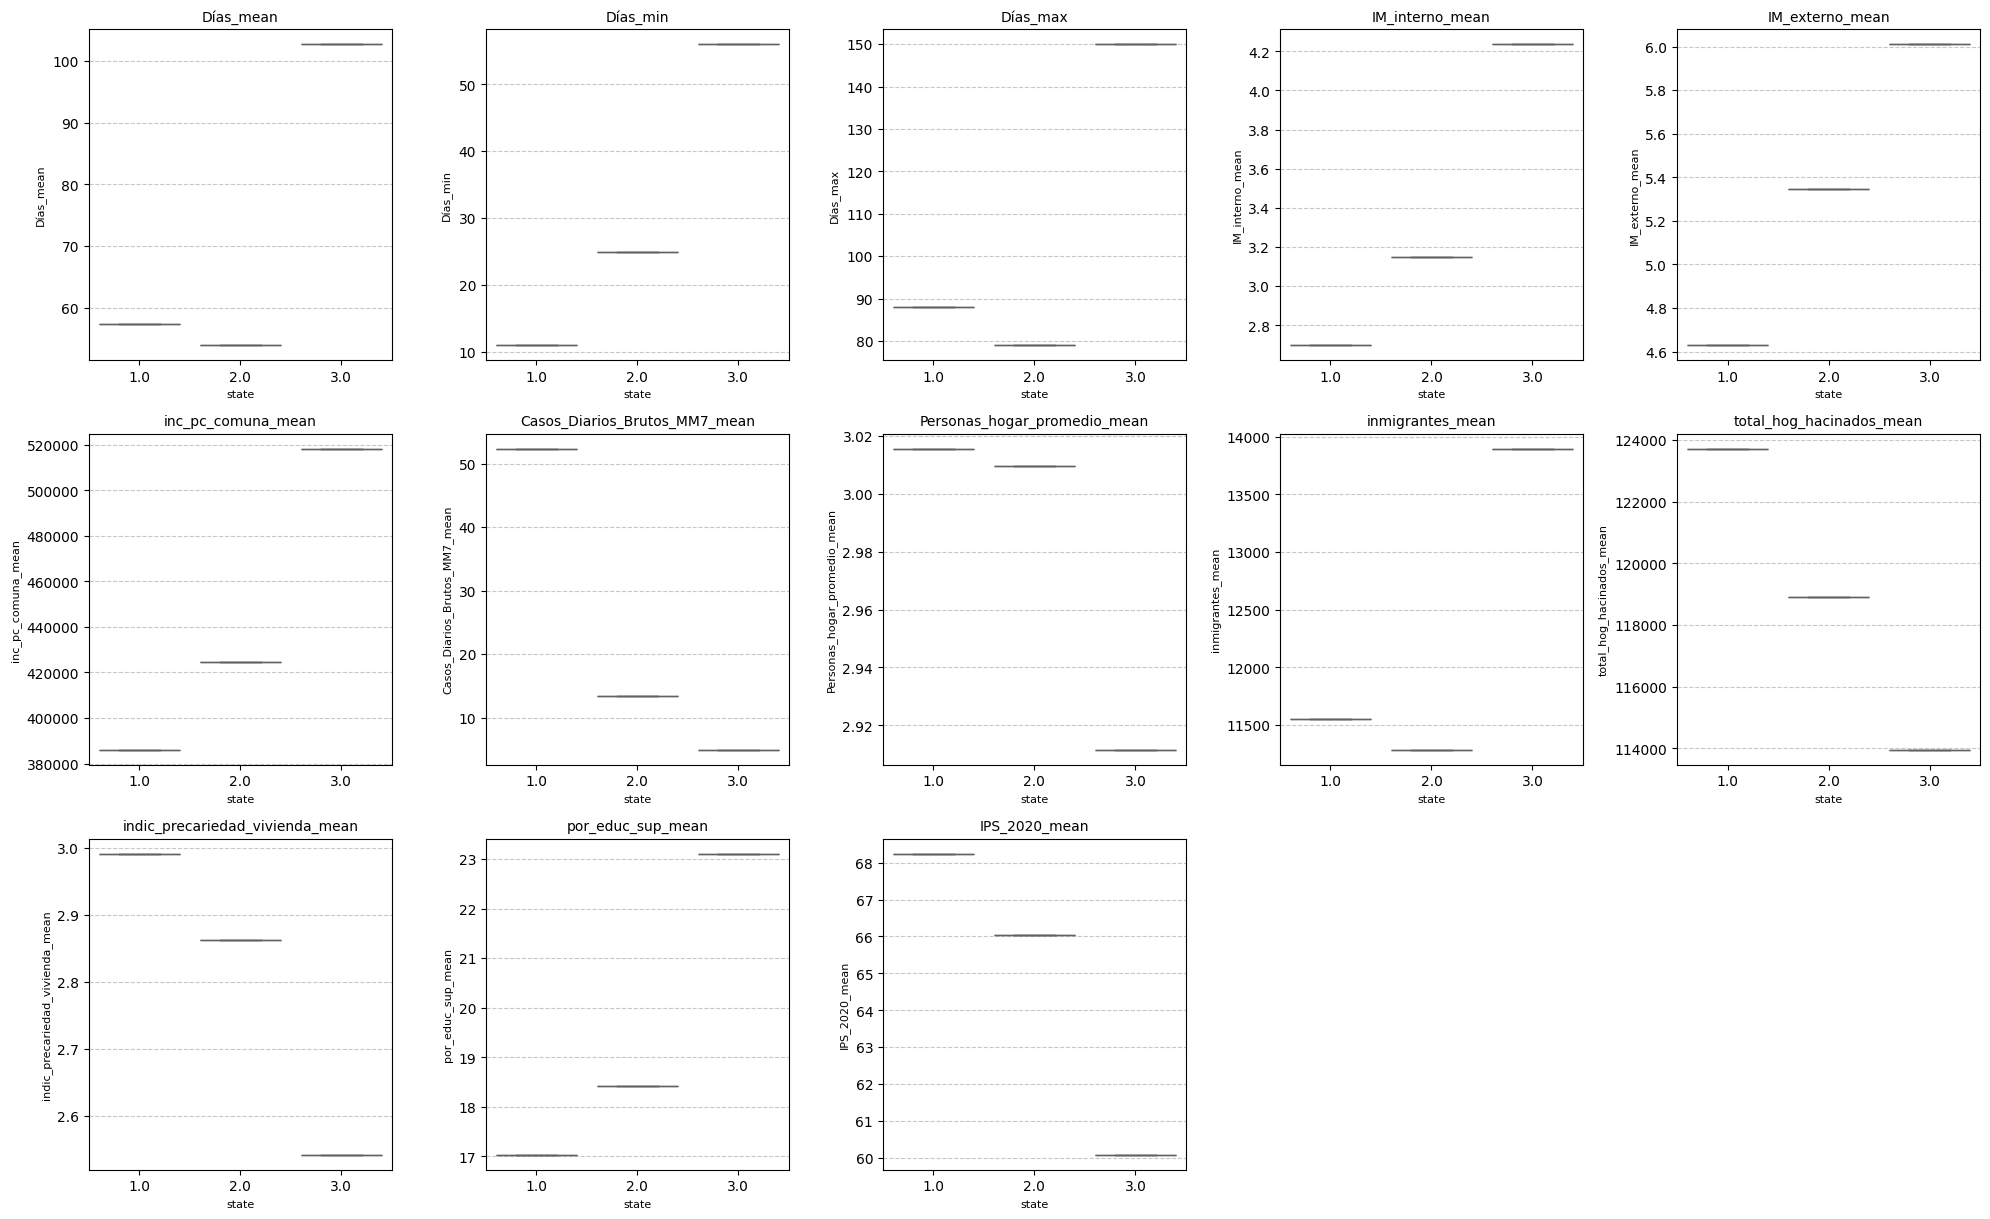

In [67]:
# Definir la paleta de colores basada en severidad
custom_palette = {
    '1.0': 'Tomato',  # Leve
    '2.0': 'LightSalmon',  # Moderado
    '3.0': 'PeachPuff'   # Severo
}

# Variables que queremos graficar
variables = ['Días_mean', 'Días_min', 'Días_max',
       'IM_interno_mean', 'IM_externo_mean', 'inc_pc_comuna_mean',
       'Casos_Diarios_Brutos_MM7_mean', 'Personas_hogar_promedio_mean',
       'inmigrantes_mean', 'total_hog_hacinados_mean',
       'indic_precariedad_vivienda_mean', 'por_educ_sup_mean',
       'IPS_2020_mean']

# Configuración de la figura
n_rows = 5  # Número de filas
n_cols = 5  # Número de columnas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))  # Ajusta el tamaño total

# Aplanar los ejes para iterar más fácilmente
axes = axes.ravel()

# Crear los boxplots para cada variable sin leyendas individuales
for i, var in enumerate(variables):
    sns.boxplot(data=estadisticas_estado_ponderadas, x='state', y=var, hue='state', palette=custom_palette, ax=axes[i], dodge=False)
    #axes[i].legend_.remove()  # Eliminar leyenda individual
    axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xlabel('state', fontsize=8)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Eliminar cualquier subplot sobrante si hay más ejes que gráficos
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

In [68]:
# Reestructurar transition_matrix para obtener probabilidades de transición por muestra
n_samples, n_states, _ = transition_matrix.shape

# Remapear índices de los estados
transitions_list = []
for t in range(n_samples):
    for i in range(n_states):
        for j in range(n_states):
            transitions_list.append({
                "sample": t,
                f"Trans_{i+1}->{j+1}": transition_matrix[t, i, j]  # Remapear 0->1, 1->2, 2->3
            })

# Convertir a DataFrame
transitions_df = pd.DataFrame(transitions_list).groupby("sample").mean().reset_index(drop=True)

print("Transiciones estructuradas:")
print(transitions_df.head())


Transiciones estructuradas:
   Trans_1->1  Trans_1->2    Trans_1->3  Trans_2->1  Trans_2->2  Trans_2->3  \
0    0.998081    0.010618  1.002178e-09    0.001919    0.987952    0.007742   
1    0.999127    0.017619  1.700575e-09    0.000873    0.981643    0.008880   
2    0.999760    0.037652  3.891806e-09    0.000240    0.962112    0.010147   
3    0.996715    0.012694  9.821783e-10    0.003285    0.984042    0.015390   
4    0.999944    0.109606  1.173756e-08    0.000056    0.890319    0.017357   

     Trans_3->1  Trans_3->2  Trans_3->3  
0  1.770769e-15    0.001430    0.992258  
1  8.774030e-17    0.000738    0.991120  
2  7.111755e-19    0.000236    0.989853  
3  4.957474e-15    0.003264    0.984610  
4  1.846976e-21    0.000074    0.982643  


In [69]:
# Seleccionar covariables relevantes
covariates_df = viterbi_merged[[
    'IM_interno', 'IM_externo', 
    'inc_pc_comuna', 'Personas_hogar_promedio', 'inmigrantes', 
    'total_hog_hacinados', 'indic_precariedad_vivienda', 
    'por_educ_sup', 'IPS_2020'
]].reset_index(drop=True)

# Combinar con transiciones
analysis_df = pd.concat([covariates_df, transitions_df], axis=1)
print("Datos combinados para análisis:")
print(analysis_df.head())

Datos combinados para análisis:
   IM_interno  IM_externo  inc_pc_comuna  Personas_hogar_promedio  \
0    1.970381    7.804008      267197.56                 3.145581   
1    1.845790    7.471452      267197.56                 3.145581   
2    1.678598    6.891732      267197.56                 3.145581   
3    1.736766    8.317872      267197.56                 3.145581   
4    1.331296    6.378498      267197.56                 3.145581   

   inmigrantes  total_hog_hacinados  indic_precariedad_vivienda  por_educ_sup  \
0         3606                68120                    3.395792          11.9   
1         3606                68120                    3.395792          11.9   
2         3606                68120                    3.395792          11.9   
3         3606                68120                    3.395792          11.9   
4         3606                68120                    3.395792          11.9   

   IPS_2020  Trans_1->1  Trans_1->2    Trans_1->3  Trans_2->1  Tra

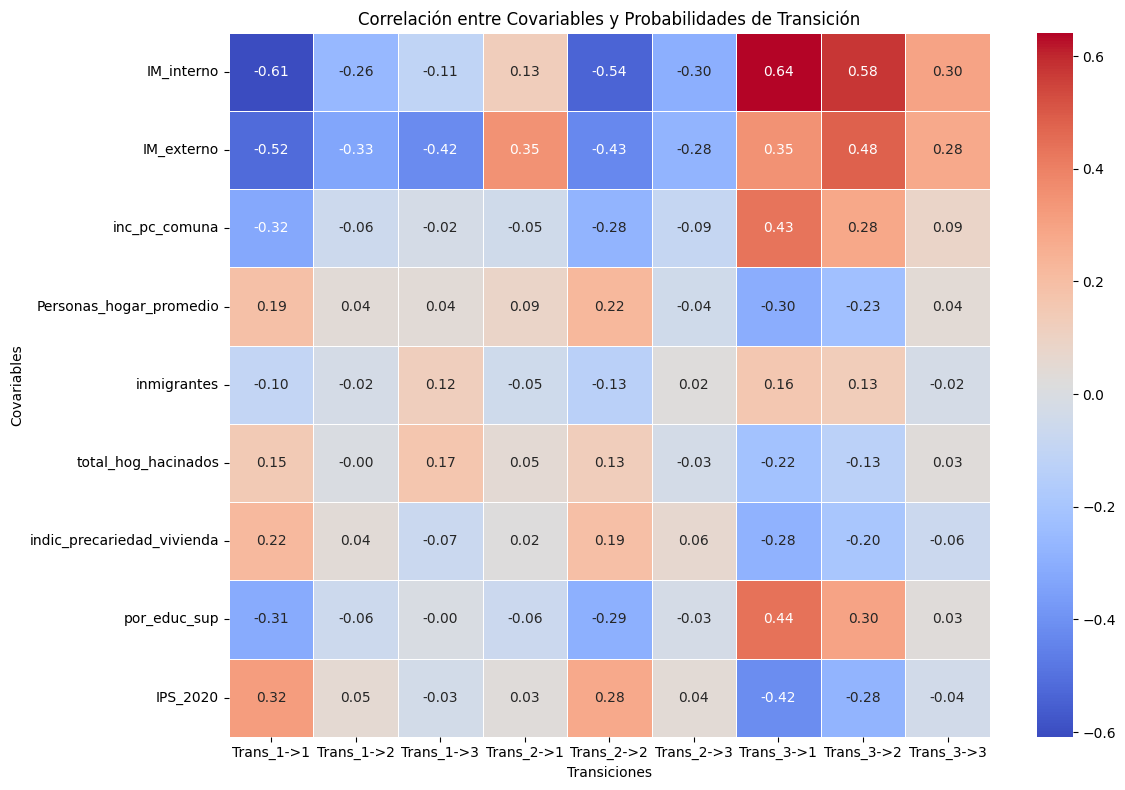

In [70]:
# Calcular la matriz de correlación
correlaciones = analysis_df.corr().loc[
    covariates_df.columns, 
    transitions_df.columns
]

# Visualizar el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlación entre Covariables y Probabilidades de Transición")
plt.xlabel("Transiciones")
plt.ylabel("Covariables")
plt.tight_layout()
plt.show()


In [72]:
# Crear lista para almacenar las transiciones
transiciones = []

# Recorrer todas las matrices de transición generadas
for idx, matriz in enumerate(transition_matrix):
    for from_state in range(len(matriz)):
        for to_state in range(len(matriz[from_state])):
            transiciones.append({
                'Día_original':  viterbi_merged.iloc[idx]['dias'],  # Día original en la base final
                'Día_correlativo': idx,  # Índice o día correlativo generado
                'Comuna': viterbi_merged.iloc[idx]['Comuna'],  # Comuna asociada al día
                'from_state': from_state + 1,  # Estado origen (ajustar a 1, 2, 3)
                'to_state': to_state + 1,     # Estado destino (ajustar a 1, 2, 3)
                'probability': matriz[from_state][to_state]
            })

# Convertir lista a DataFrame
transiciones_df = pd.DataFrame(transiciones)

# Crear columnas de transiciones (e.g., Trans_1->2)
transiciones_df['Transición'] = (
    "Trans_" + transiciones_df['from_state'].astype(str) + "->" + transiciones_df['to_state'].astype(str)
)

# Pivotear para tener las transiciones como columnas
transiciones_df = transiciones_df.pivot(
    index=['Comuna', 'Día_original', 'Día_correlativo'],  # Agregar ambas referencias de día
    columns='Transición',
    values='probability'
).reset_index()

# Inspeccionar el DataFrame de transiciones
print("DataFrame de transiciones actualizado:")
print(transiciones_df.head())



DataFrame de transiciones actualizado:
Transición     Comuna  Día_original  Día_correlativo  Trans_1->1  Trans_1->2  \
0           Cerrillos             2                0    0.998081    0.010618   
1           Cerrillos             3                1    0.999127    0.017619   
2           Cerrillos             4                2    0.999760    0.037652   
3           Cerrillos             5                3    0.996715    0.012694   
4           Cerrillos             6                4    0.999944    0.109606   

Transición    Trans_1->3  Trans_2->1  Trans_2->2  Trans_2->3    Trans_3->1  \
0           1.002178e-09    0.001919    0.987952    0.007742  1.770769e-15   
1           1.700575e-09    0.000873    0.981643    0.008880  8.774030e-17   
2           3.891806e-09    0.000240    0.962112    0.010147  7.111755e-19   
3           9.821783e-10    0.003285    0.984042    0.015390  4.957474e-15   
4           1.173756e-08    0.000056    0.890319    0.017357  1.846976e-21   

Transición 

In [73]:
# Convertir las transiciones en formato "long"
transiciones_long = pd.melt(
    transiciones_df,
    id_vars=['Comuna', 'Día_original', 'Día_correlativo'],  # Incluir ambas columnas de días
    value_vars=['Trans_1->1', 'Trans_1->2', 'Trans_1->3', 
                'Trans_2->1', 'Trans_2->2', 'Trans_2->3', 
                'Trans_3->1', 'Trans_3->2', 'Trans_3->3'],
    var_name='Transición',
    value_name='Probabilidad_Transición'
)

# Realizar el merge para agregar las covariables desde base_final
glmm_data = transiciones_long.merge(
    viterbi_merged[['Comuna', 'dias', 'IM_interno', 'IM_externo', 'TasaCasosAcumulados', 
                'Casos_Diarios_Brutos', 'Casos_Diarios_Brutos_MM7', 'inc_pc_comuna',
                'Personas_hogar_promedio', 'inmigrantes', 'total_hog_hacinados', 
                'indic_precariedad_vivienda', 'por_educ_sup', 'IPS_2020']],
    left_on=['Comuna', 'Día_original'],  # Usar Día_original para coincidir con base_final
    right_on=['Comuna', 'dias'],         # La columna en base_final es 'dias'
    how='left'
)

# Inspeccionar el resultado
print("Datos preparados para GLMM (en formato long con covariables adicionales):")
print(glmm_data.head())


Datos preparados para GLMM (en formato long con covariables adicionales):
      Comuna  Día_original  Día_correlativo  Transición  \
0  Cerrillos             2                0  Trans_1->1   
1  Cerrillos             3                1  Trans_1->1   
2  Cerrillos             4                2  Trans_1->1   
3  Cerrillos             5                3  Trans_1->1   
4  Cerrillos             6                4  Trans_1->1   

   Probabilidad_Transición  dias  IM_interno  IM_externo  TasaCasosAcumulados  \
0                 0.998081     2    1.970381    7.804008             2.248303   
1                 0.999127     3    1.845790    7.471452             4.496605   
2                 0.999760     4    1.678598    6.891732             4.496605   
3                 0.996715     5    1.736766    8.317872             4.496605   
4                 0.999944     6    1.331296    6.378498             4.496605   

   Casos_Diarios_Brutos  Casos_Diarios_Brutos_MM7  inc_pc_comuna  \
0              2

In [74]:
glmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65484 entries, 0 to 65483
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Comuna                      65484 non-null  object 
 1   Día_original                65484 non-null  int64  
 2   Día_correlativo             65484 non-null  int64  
 3   Transición                  65484 non-null  object 
 4   Probabilidad_Transición     65484 non-null  float64
 5   dias                        65484 non-null  int64  
 6   IM_interno                  65484 non-null  float64
 7   IM_externo                  65484 non-null  float64
 8   TasaCasosAcumulados         65484 non-null  float64
 9   Casos_Diarios_Brutos        65484 non-null  float64
 10  Casos_Diarios_Brutos_MM7    65484 non-null  float64
 11  inc_pc_comuna               65484 non-null  float64
 12  Personas_hogar_promedio     65484 non-null  float64
 13  inmigrantes                 654

AttributeError: module 'matplotlib.pyplot' has no attribute 'handles'

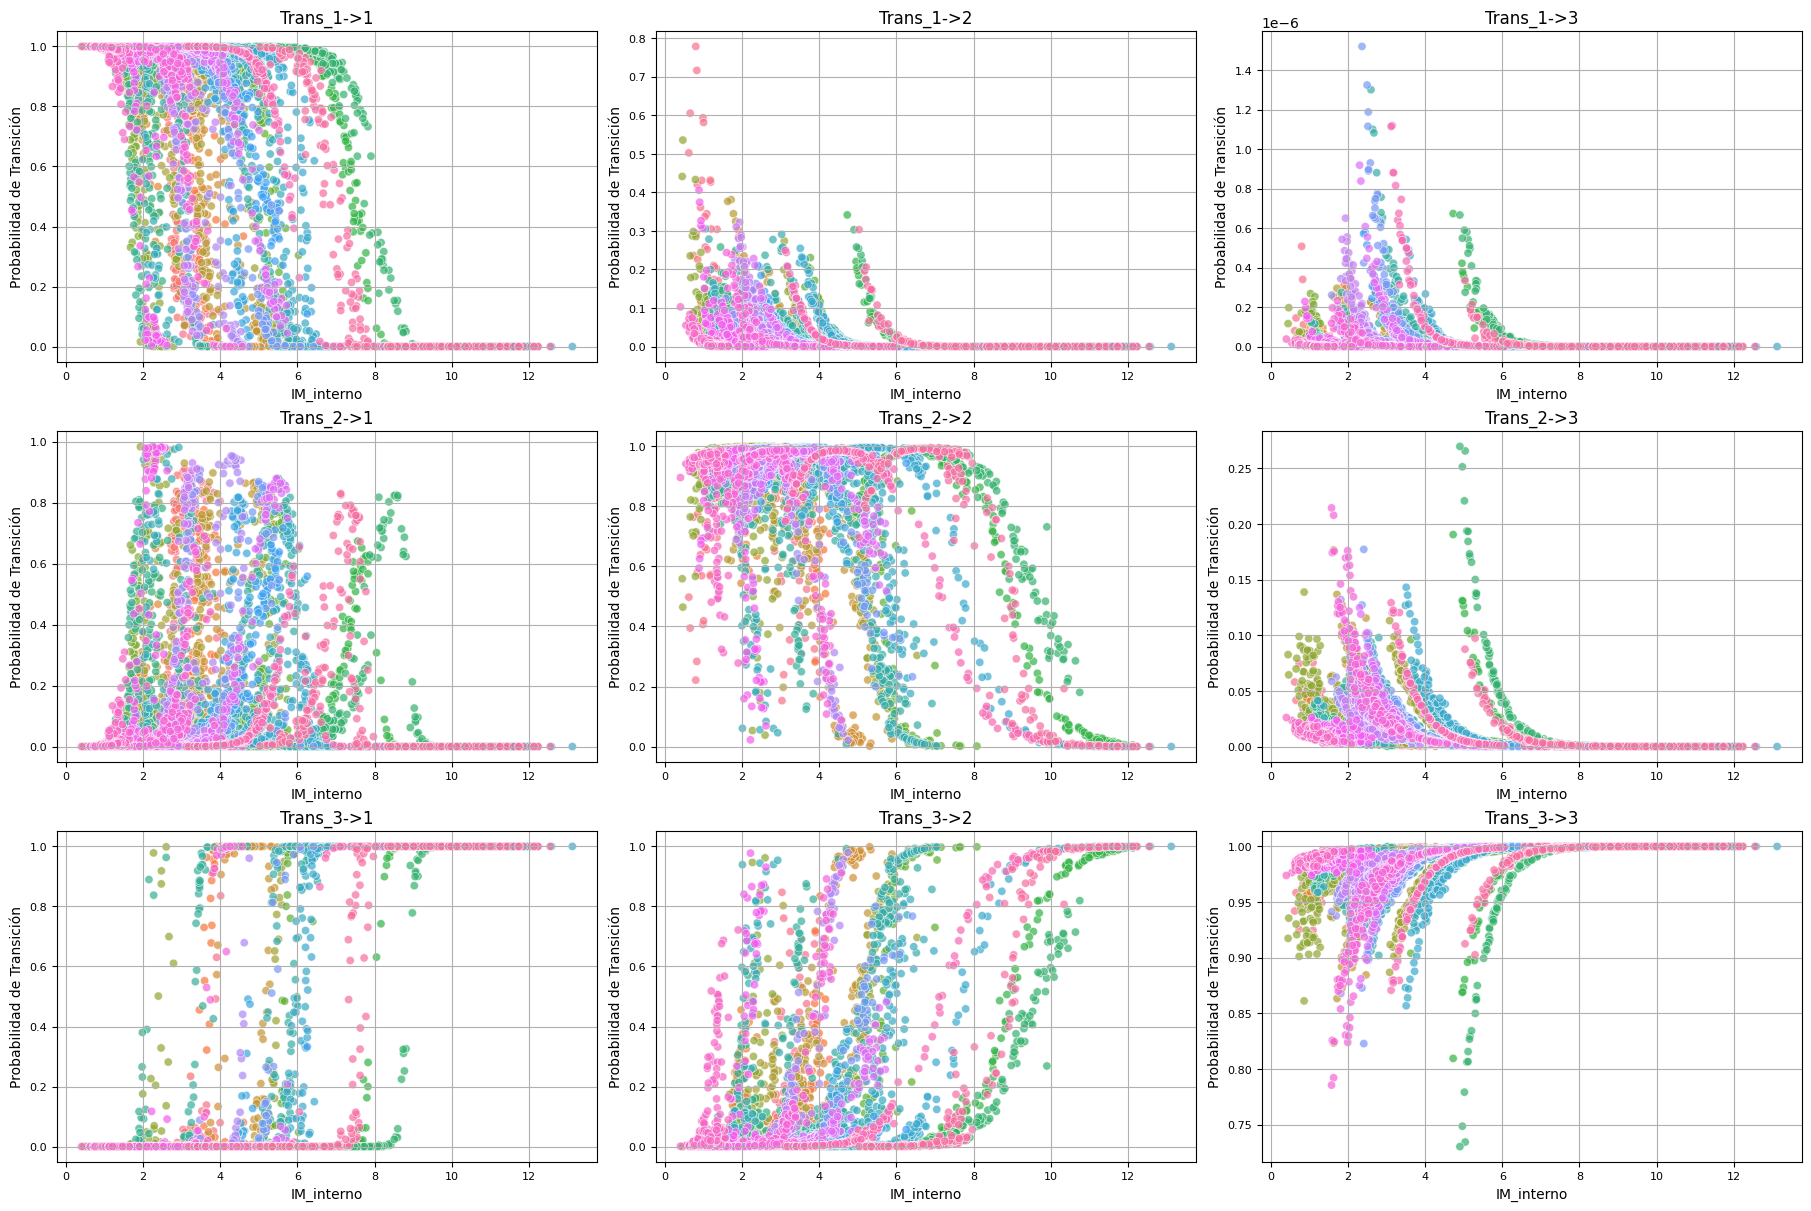

In [75]:

# Lista de transiciones únicas
transiciones_unicas = glmm_data['Transición'].unique()

# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18,12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear un mapa de colores para las comunas
palette = sns.color_palette("husl", n_colors=glmm_data['Comuna'].nunique())

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=glmm_data[glmm_data['Transición'] == transicion],
        x='IM_interno',
        y='Probabilidad_Transición',
        hue='Comuna',  # Color basado en la comuna
        palette=palette,
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('IM_interno', fontsize=10)
    axes[i].set_ylabel('Probabilidad de Transición', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
#handles, labels = sns.scatterplot(
#    data=glmm_data,
#    x='IM_interno',
#    y='Probabilidad_Transición',
#    hue='Comuna',
#    palette=palette,
#    legend=True
#).get_legend_handles_labels()

fig.legend(
    plt.handles, plt.labels, loc='center right', title='Comuna',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.2, 0.5),
    frameon=True  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relación entre IM_interno y Probabilidad de Transición por Comuna', fontsize=16)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'handles'

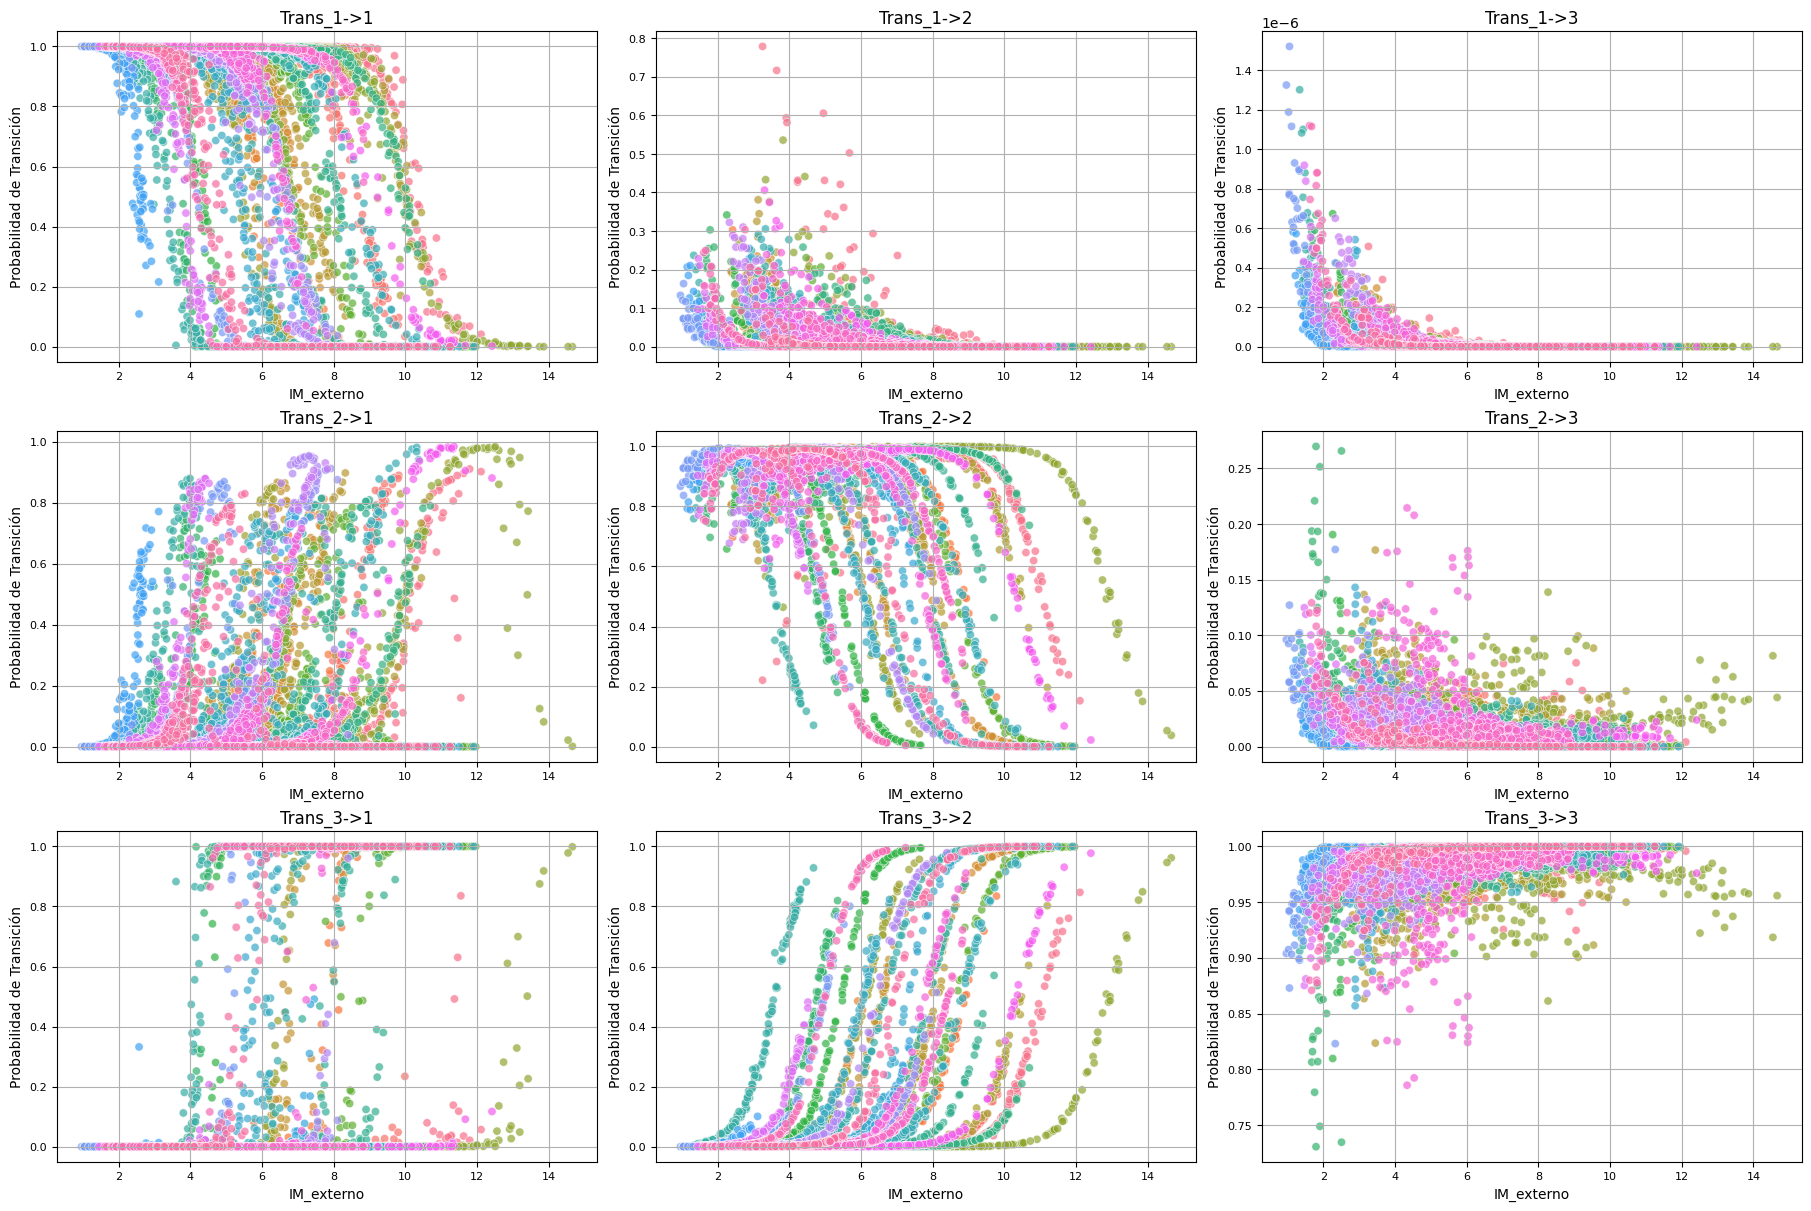

In [76]:

# Lista de transiciones únicas
transiciones_unicas = glmm_data['Transición'].unique()

# Configurar la figura con subplots
num_transiciones = len(transiciones_unicas)
fig, axes = plt.subplots(
    nrows=(num_transiciones + 2) // 3,  # Filas (3 gráficos por fila)
    ncols=3,  # Columnas
    figsize=(18,12),
    constrained_layout=True
)

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear un mapa de colores para las comunas
palette = sns.color_palette("husl", n_colors=glmm_data['Comuna'].nunique())

# Crear gráficos separados por transición
for i, transicion in enumerate(transiciones_unicas):
    sns.scatterplot(
        data=glmm_data[glmm_data['Transición'] == transicion],
        x='IM_externo',
        y='Probabilidad_Transición',
        hue='Comuna',  # Color basado en la comuna
        palette=palette,
        alpha=0.7,
        legend=False,  # Eliminar leyendas de los subplots individuales
        ax=axes[i]
    )
    axes[i].set_title(f'{transicion}', fontsize=12)
    axes[i].set_xlabel('IM_externo', fontsize=10)
    axes[i].set_ylabel('Probabilidad de Transición', fontsize=10)
    axes[i].grid(True)
    axes[i].tick_params(axis='both', labelsize=8)

# Crear una única leyenda para toda la figura
#handles, labels = sns.scatterplot(
#    data=glmm_data,
#    x='IM_interno',
#    y='Probabilidad_Transición',
#    hue='Comuna',
#    palette=palette,
#    legend=True
#).get_legend_handles_labels()

fig.legend(
    plt.handles, plt.labels, loc='center right', title='Comuna',
    fontsize=14, title_fontsize=14, bbox_to_anchor=(1.2, 0.5),
    frameon=True  # Agregar un cuadro a la leyenda
)

# Ajustar el espacio entre gráficos y la leyenda
plt.subplots_adjust(right=1.5)  # Dar más espacio horizontal para la leyenda

# Deshabilitar los subplots vacíos si hay más ejes que gráficos
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Título general
fig.suptitle('Relación entre IM_interno y Probabilidad de Transición por Comuna', fontsize=16)
plt.show()